In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


Get daily data for a specific ticker for the past 20 years from alpha vantage. I chose daily data to avoid api limits, and i will add technical indicators via pandas-ta later. 

In [2]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

# Set your API key
api_key = 'AWUBWW71DWE5KISU'

# Fetch daily data
ts = TimeSeries(key=api_key, output_format='pandas')
ticker = 'AAPL'
data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')

# Rename columns for readability
data = data.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
})

# Convert index to datetime and sort it
data.index = pd.to_datetime(data.index)  # Ensure proper datetime index
data = data.sort_index()  # Sort chronologically

# Filter the last 20 years of data
start_date = '2005-01-01'
end_date = '2025-01-01'
data = data.loc[start_date:end_date]

# Add additional features
data['Return'] = data['Close'].pct_change()  # Daily returns
data['Target'] = (data['Return'] > 0).astype(int)  # Binary target

# Drop NaN rows (resulting from pct_change)
data.dropna(inplace=True)

# Save or preview the data
data.to_csv(f'{ticker}_20_years_daily_data.csv')
print(data.head())


              Open   High    Low  Close      Volume    Return  Target
date                                                                 
2005-01-04  63.800  65.47  62.97  63.94  19585900.0  0.010270       1
2005-01-05  64.470  65.25  64.05  64.50  12150600.0  0.008758       1
2005-01-06  64.685  64.91  63.33  64.55  12599200.0  0.000775       1
2005-01-07  65.000  69.63  64.75  69.25  39775900.0  0.072812       1
2005-01-10  69.900  70.70  67.88  68.96  30809100.0 -0.004188       0


Adding some (actually as much as i could) technical indicators. I added the technical indicators used in the papers mentioned in the beginning of the project. I also added all the indicators i could find in a brute force fashion in order to do elimination later.

In [3]:
import pandas as pd
import pandas_ta as ta

# Load your data
data = pd.read_csv('AAPL_20_years_daily_data.csv', index_col='date', parse_dates=True)

# Ensure column names are lowercase for compatibility
data.rename(columns=lambda x: x.lower(), inplace=True)

# Extended list of indicators
indicators_with_args = [
    {"name": "willr", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "length": 14}},

    # Trend Indicators
    {"name": "sma", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "ema", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "wma", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "tema", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "kama", "kwargs": {"close": data["close"], "length": 10}},
    
    # Momentum Indicators
    {"name": "rsi", "kwargs": {"close": data["close"], "length": 14}},
    {"name": "macd", "kwargs": {"close": data["close"]}},
    {"name": "mom", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "roc", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "stoch", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "k": 14, "d": 3}},
    
    # Volatility Indicators
    {"name": "atr", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "length": 14}},
    {"name": "bbands", "kwargs": {"close": data["close"], "length": 20}},
    {"name": "donchian", "kwargs": {"high": data["high"], "low": data["low"], "length": 20}},
    
    # Volume Indicators
    {"name": "obv", "kwargs": {"close": data["close"], "volume": data["volume"]}},
    {"name": "adosc", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "volume": data["volume"]}},
    {"name": "cmf", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "volume": data["volume"]}},
]

# Apply each indicator dynamically
for indicator in indicators_with_args:
    try:
        method = getattr(ta, indicator["name"])
        result = method(**indicator["kwargs"])
        if isinstance(result, pd.DataFrame):
            for col in result.columns:
                data[col] = result[col]
        elif isinstance(result, pd.Series):
            data[indicator["name"]] = result
    except Exception as e:
        print(f"Could not add {indicator['name']}: {e}")

# Add the target column
data["target"] = (data["close"].pct_change() > 0).astype(int)

# Drop rows with NaN values
data.dropna(inplace=True)

# Save the processed data
data.to_csv("AAPL_with_extended_indicators.csv")

# Preview the data
print(data.head())
data["close"].info


             open   high    low  close      volume    return  target  \
date                                                                   
2005-02-22  86.30  88.30  85.29  85.29  21773100.0 -0.017510       0   
2005-02-23  86.69  88.45  85.55  88.23  24021100.0  0.034471       1   
2005-02-24  88.48  89.31  87.73  88.93  27125500.0  0.007934       1   
2005-02-25  89.62  89.91  88.19  88.99  16348400.0  0.000675       1   
2005-02-28  44.68  45.14  43.96  44.86  11635900.0 -0.495898       0   

                willr     sma        ema  ...  BBM_20_2.0  BBU_20_2.0  \
date                                      ...                           
2005-02-22 -39.310830  84.229  84.399928  ...     80.1430   90.848780   
2005-02-23 -18.635724  84.962  85.096305  ...     80.9520   91.533889   
2005-02-24 -13.713080  85.981  85.793340  ...     81.7860   92.119387   
2005-02-25 -13.291139  87.044  86.374551  ...     82.6035   92.490630   
2005-02-28 -98.081841  83.409  78.826451  ...     81.1475

<bound method Series.info of date
2005-02-22     85.29
2005-02-23     88.23
2005-02-24     88.93
2005-02-25     88.99
2005-02-28     44.86
               ...  
2024-12-24    258.20
2024-12-26    259.02
2024-12-27    255.59
2024-12-30    252.20
2024-12-31    250.42
Name: close, Length: 4999, dtype: float64>

In [4]:
print("Raw Close Values:")
print(data['close'].head())


Raw Close Values:
date
2005-02-22    85.29
2005-02-23    88.23
2005-02-24    88.93
2005-02-25    88.99
2005-02-28    44.86
Name: close, dtype: float64


Let's do some EDA before jumping in to build our models.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4999 entries, 2005-02-22 to 2024-12-31
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           4999 non-null   float64
 1   high           4999 non-null   float64
 2   low            4999 non-null   float64
 3   close          4999 non-null   float64
 4   volume         4999 non-null   float64
 5   return         4999 non-null   float64
 6   target         4999 non-null   int32  
 7   willr          4999 non-null   float64
 8   sma            4999 non-null   float64
 9   ema            4999 non-null   float64
 10  wma            4999 non-null   float64
 11  tema           4999 non-null   float64
 12  kama           4999 non-null   float64
 13  rsi            4999 non-null   float64
 14  MACD_12_26_9   4999 non-null   float64
 15  MACDh_12_26_9  4999 non-null   float64
 16  MACDs_12_26_9  4999 non-null   float64
 17  mom            4999 non-null   flo

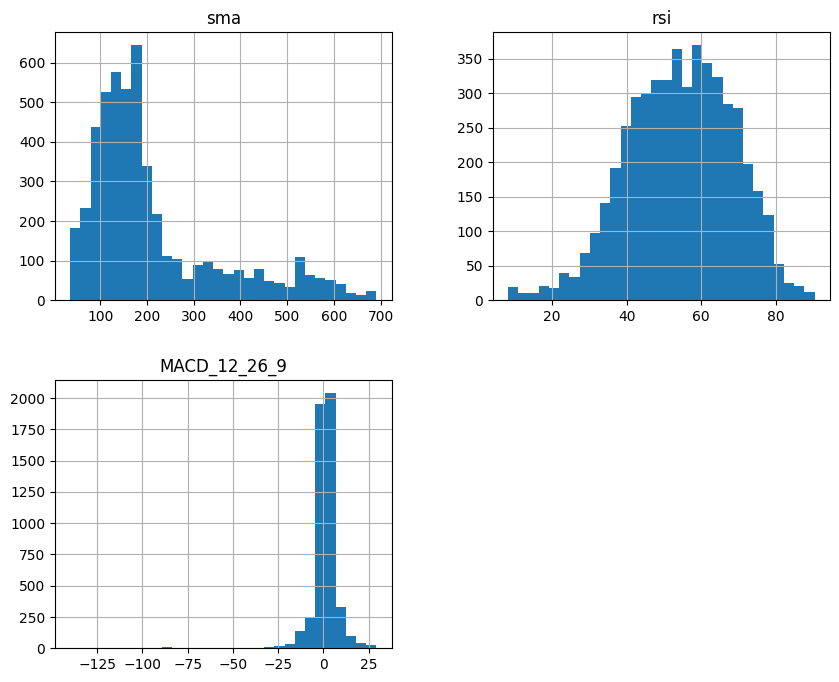

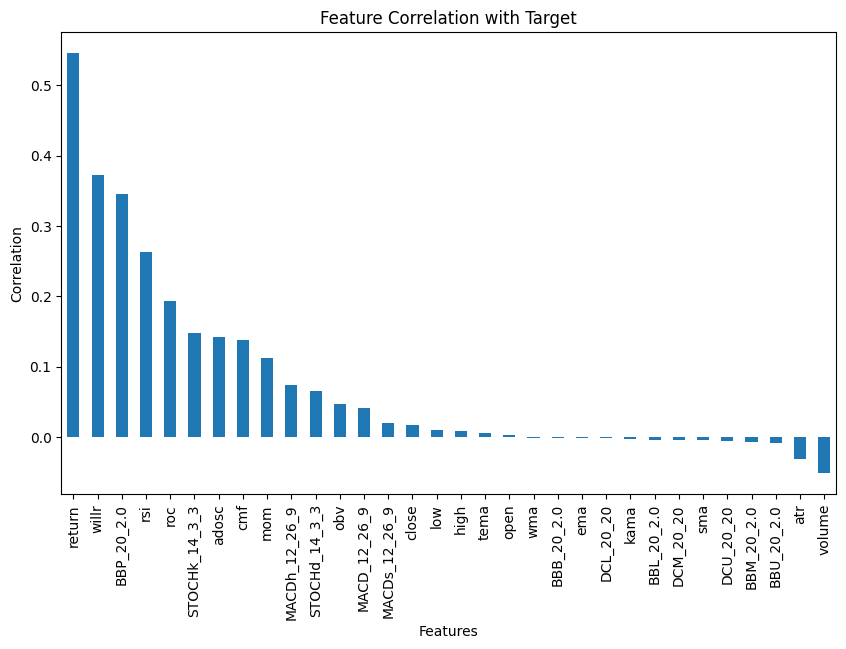

target
1    0.528106
0    0.471894
Name: proportion, dtype: float64


In [5]:
print(data.info())
print(data.describe())
print(data.isnull().sum())

data[['sma', 'rsi', 'MACD_12_26_9']].hist(bins=30, figsize=(10, 8))

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation of all features with the target
correlations = data.corr()['target'].sort_values(ascending=False)

# Display top correlations
print("Top correlations with target:")
print(correlations.head(10))

# Plot the top features correlated with the target

plt.figure(figsize=(10, 6))
correlations.drop('target').plot(kind='bar')
plt.title('Feature Correlation with Target')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()


print(data['target'].value_counts(normalize=True))




In [6]:
# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale features
feature_columns = data.columns.difference(['close'])  # Exclude the target 'close'
data[feature_columns] = feature_scaler.fit_transform(data[feature_columns])

# Scale target
data['close_scaled'] = target_scaler.fit_transform(data[['close']])


In [7]:
# Step 3: Define Features and Target
X = data[feature_columns].values  # Scaled features
y = data['close_scaled'].values  # Scaled target (close price)

# Step 4: Create Sequences for LSTM
window_size = 30  # Sequence length for LSTM

def create_sequences(data, target, window_size):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i + window_size])
        y_seq.append(target[i + window_size])
    return np.array(X_seq), np.array(y_seq)

X_sequences, y_sequences = create_sequences(X, y, window_size)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Step 5: Build and Train the LSTM Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)  # Linear activation for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,651 (65.04 KB)

 Trainable params: 16,651 (65.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0268 - mae: 0.1149 - val_loss: 9.7463e-04 - val_mae: 0.0211
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - mae: 0.0467 - val_loss: 2.7829e-04 - val_mae: 0.0119
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mae: 0.0359 - val_loss: 4.0892e-04 - val_mae: 0.0167
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mae: 0.0338 - val_loss: 1.9676e-04 - val_mae: 0.0107
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mae: 0.0327 - val_loss: 4.0993e-04 - val_mae: 0.0167
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - mae: 0.0279 - val_loss: 3.5880e-04 - val_mae: 0.0154
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - mae: 0.0283 - val_loss: 1.3368e-04 - val_mae: 0.0085
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - mae: 0.0275 - val_loss: 5.1333e-04 - val_mae: 0.0206
Epoch 9/10
100/100 ━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3796e-04 - mae: 0.0142
Test Loss (MSE): 0.00035428133560344577
Test MAE: 0.01428486593067646
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Squared Error (MSE): 0.0003542813301224142
Mean Absolute Error (MAE): 0.01428486521582177
R-squared (R2): 0.9921173207122288


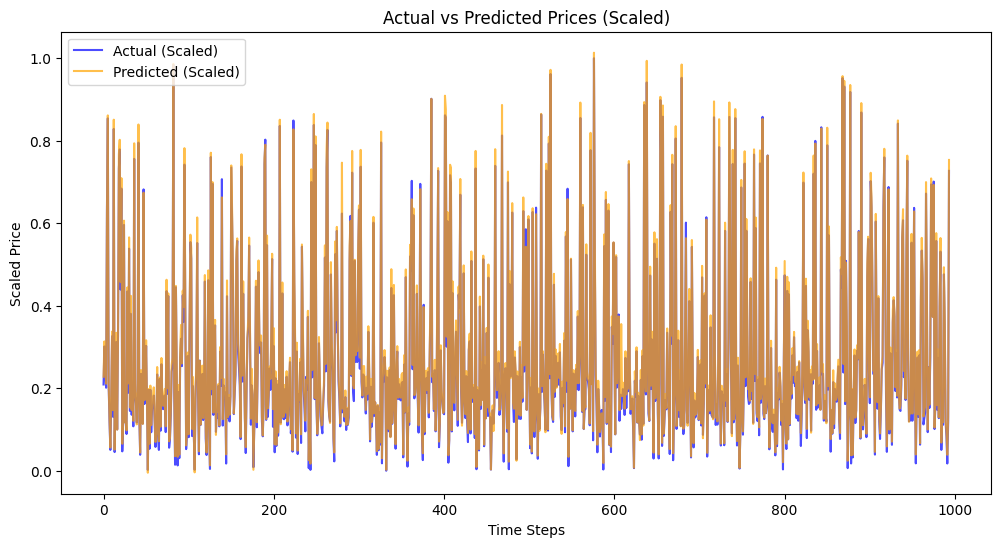

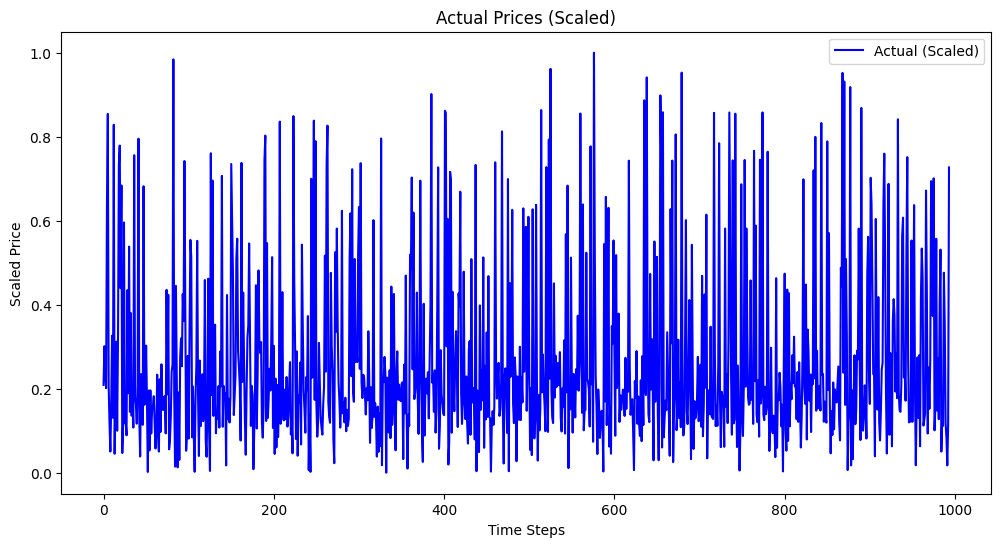

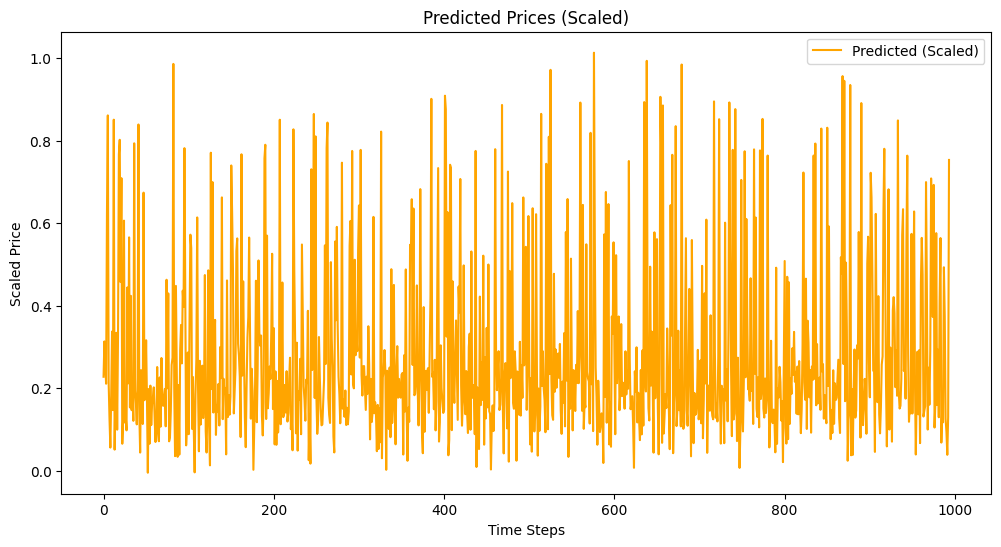

In [8]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test data
y_pred = model.predict(X_test)

# Evaluation Metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {test_mse}")
print(f"Mean Absolute Error (MAE): {test_mae}")
print(f"R-squared (R2): {test_r2}")

# Plot predicted vs actual (scaled values)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted (Scaled)', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Prices (Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Separate Plots for Clarity
# Plot actual scaled prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue')
plt.title('Actual Prices (Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Plot predicted scaled prices
plt.figure(figsize=(12, 6))
plt.plot(y_pred, label='Predicted (Scaled)', color='orange')
plt.title('Predicted Prices (Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,259 (114.29 KB)

 Trainable params: 29,259 (114.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0190 - mae: 0.0902 - val_loss: 0.0011 - val_mae: 0.0252
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048 - mae: 0.0441 - val_loss: 3.2438e-04 - val_mae: 0.0132
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - mae: 0.0405 - val_loss: 3.8285e-04 - val_mae: 0.0139
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - mae: 0.0338 - val_loss: 2.9054e-04 - val_mae: 0.0119
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - mae: 0.0295 - val_loss: 2.1828e-04 - val_mae: 0.0103
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - mae: 0.0288 - val_loss: 4.0297e-04 - val_mae: 0.0174
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - mae: 0.0294 - val_loss: 5.0778e-04 - val_mae: 0.0197
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - mae: 0.0281 - val_loss: 1.7450e-04 - val_mae: 0.0093
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━

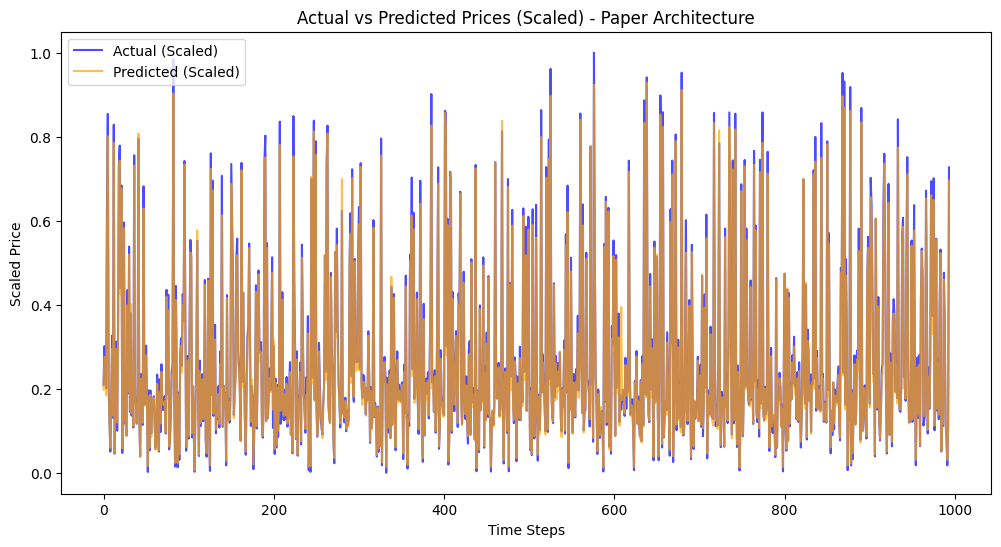

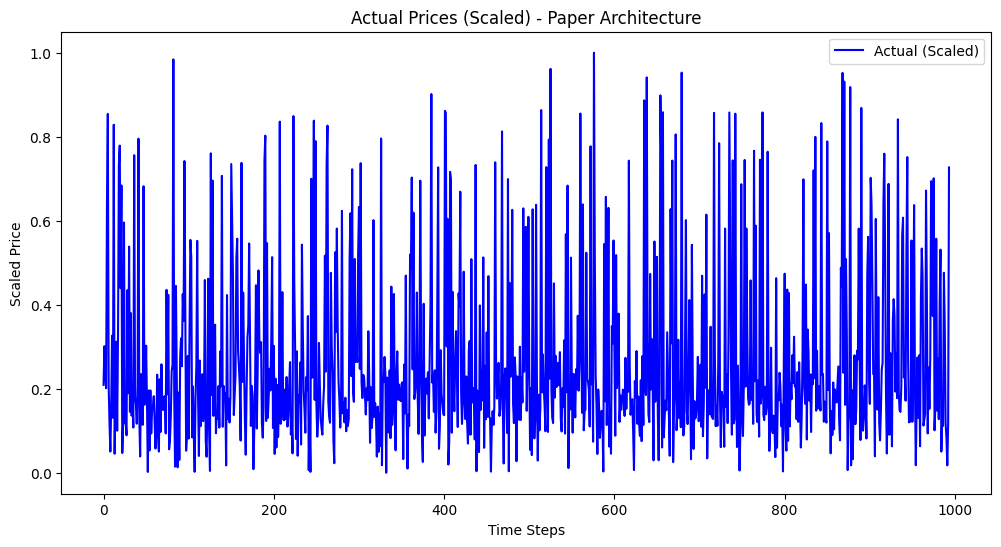

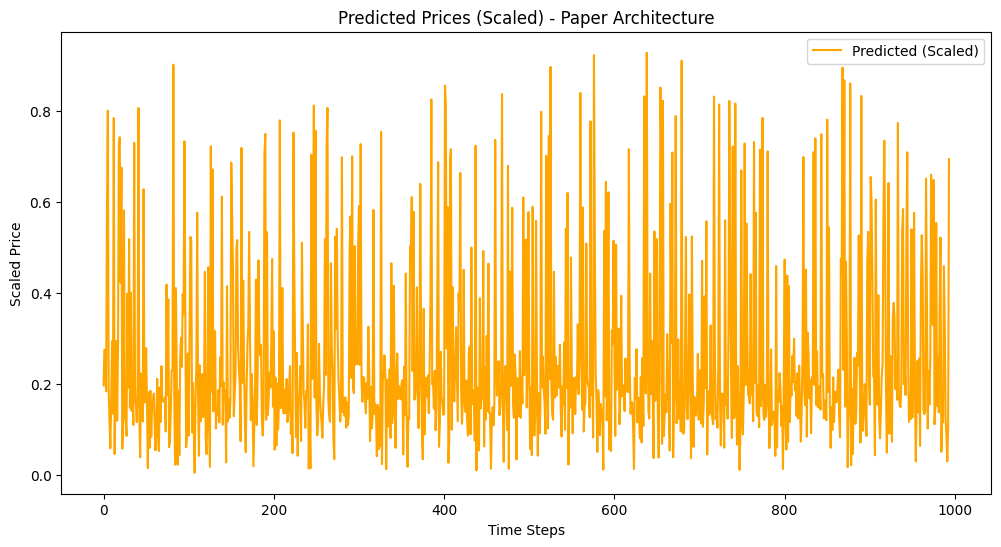

In [9]:
model = Sequential([
    # CNN layers
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
    MaxPooling1D(pool_size=2),

    # LSTM layer
    LSTM(50, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(1)  # Linear activation for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Step 6: Evaluate and Visualize Results
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test data
y_pred = model.predict(X_test)

# Evaluation Metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {test_mse}")
print(f"Mean Absolute Error (MAE): {test_mae}")
print(f"R-squared (R2): {test_r2}")

# Plot predicted vs actual (scaled values)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted (Scaled)', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Prices (Scaled) - Paper Architecture')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Separate Plots for Clarity
# Plot actual scaled prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue')
plt.title('Actual Prices (Scaled) - Paper Architecture')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Plot predicted scaled prices
plt.figure(figsize=(12, 6))
plt.plot(y_pred, label='Predicted (Scaled)', color='orange')
plt.title('Predicted Prices (Scaled) - Paper Architecture')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()


In [11]:
# Function to train and evaluate the model with a given set of features
def train_and_evaluate(X, y, feature_names, window_size=30, verbose=0):
    # Create sequences
    X_sequences, y_sequences = create_sequences(X, y, window_size)
    X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], X_sequences.shape[2]))

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

    # Build the model
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Train the model
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=verbose)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Iterative Feature Elimination
def iterative_feature_elimination(data, target, feature_columns, window_size=30):
    remaining_features = feature_columns.tolist()
    best_mse = float('inf')
    optimal_features = remaining_features[:]
    improvement = True

    while improvement and len(remaining_features) > 1:
        feature_mse = []
        for feature in remaining_features:
            # Remove one feature
            reduced_features = [f for f in remaining_features if f != feature]
            X_reduced = data[reduced_features].values

            # Train and evaluate
            mse = train_and_evaluate(X_reduced, target, reduced_features, window_size)
            feature_mse.append((feature, mse))

        # Find the feature whose removal results in the lowest MSE
        feature_mse.sort(key=lambda x: x[1])
        best_feature, best_feature_mse = feature_mse[0]

        print(f"Removing feature '{best_feature}' resulted in MSE = {best_feature_mse}")

        # Check if removing the feature improves performance
        if best_feature_mse < best_mse:
            best_mse = best_feature_mse
            remaining_features.remove(best_feature)
            optimal_features = remaining_features[:]
        else:
            improvement = False

    print("Optimal feature set:", optimal_features)
    print("Best MSE achieved:", best_mse)
    return optimal_features

# Run the iterative feature elimination
optimal_features = iterative_feature_elimination(data, y, feature_columns)


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Removing feature 'BBM_20_2.0' resulted in MSE = 0.0003886804133041893


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Removing feature 'wma' resulted in MSE = 0.00033843931983780327


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Removing feature 'target' resulted in MSE = 0.00034451293090019097
Optimal feature set: ['BBB_20_2.0', 'BBL_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHd_14_3_3', 'STOCHk_14_3_3', 'adosc', 'atr', 'cmf', 'ema', 'high', 'kama', 'low', 'mom', 'obv', 'open', 'return', 'roc', 'rsi', 'sma', 'target', 'tema', 'volume', 'willr']
Best MSE achieved: 0.00033843931983780327


The target column is a remedy from when i was trying to predict the binary value of if the close price increased or not. However this result shows us that removing it improves model performance. Let's finalize the model.

c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_95 (Conv1D)              │ (None, 28, 64)         │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_95 (MaxPooling1D) │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_96 (LSTM)                  │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,683 (112.04 KB)

 Trainable params: 28,683 (112.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0106 - mae: 0.0708 - val_loss: 7.4570e-04 - val_mae: 0.0232
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - mae: 0.0381 - val_loss: 2.7702e-04 - val_mae: 0.0130
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - mae: 0.0339 - val_loss: 4.3804e-04 - val_mae: 0.0141
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - mae: 0.0306 - val_loss: 9.9266e-04 - val_mae: 0.0214
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - mae: 0.0344 - val_loss: 1.8689e-04 - val_mae: 0.0100
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - mae: 0.0262 - val_loss: 2.2186e-04 - val_mae: 0.0103
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - mae: 0.0270 - val_loss: 1.5623e-04 - val_mae: 0.0086
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - mae: 0.0273 - val_loss: 2.5581e-04 - val_mae: 0.0123
Epoch 9/10
100/100 ━━━━

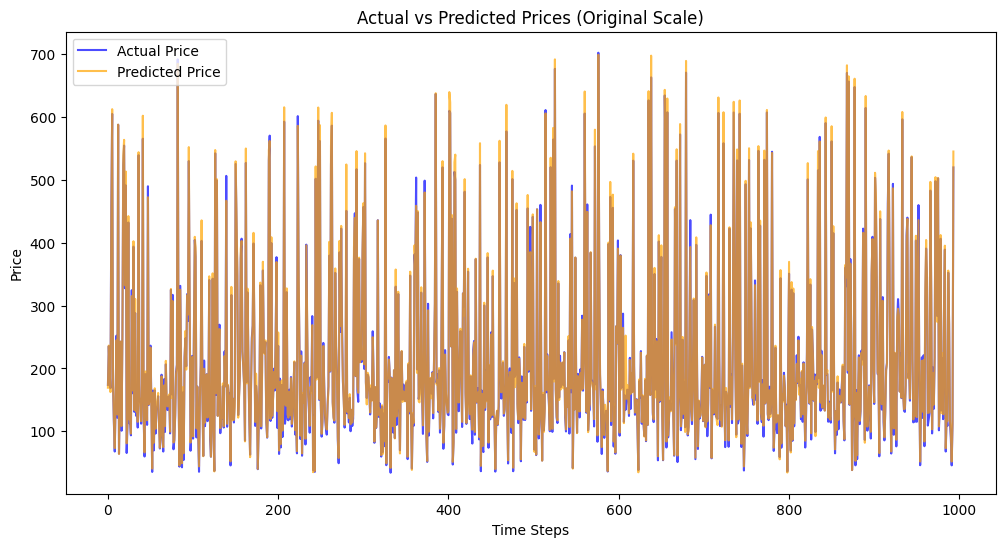

In [ ]:
# Use the optimal feature set
optimal_features = [
    'BBB_20_2.0', 'BBL_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'DCL_20_20', 
    'DCM_20_20', 'DCU_20_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
    'STOCHd_14_3_3', 'STOCHk_14_3_3', 'adosc', 'atr', 'cmf', 'ema', 'high', 'kama', 
    'low', 'mom', 'obv', 'open', 'return', 'roc', 'rsi', 'sma', 'tema', 'volume', 'willr'
]

# Prepare data with the optimal feature set
X = data[optimal_features].values
y = data['close_scaled'].values  # Scaled target

# Create sequences
X_sequences, y_sequences = create_sequences(X, y, window_size=30)

# Reshape for CNN input
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], X_sequences.shape[2]))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Build and train the model
final_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

final_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
final_model.summary()

history = final_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
test_loss, test_mae = final_model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test data
y_pred = final_model.predict(X_test)

# Metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {test_mse}")
print(f"Mean Absolute Error (MAE): {test_mae}")
print(f"R-squared (R2): {test_r2}")

# Plot actual vs predicted prices (scaled)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted (Scaled)', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Prices (Scaled) - Final Model')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()


In [14]:
from tensorflow.keras.optimizers import Adam
import random

# Define the search space
param_grid = {
    "filters": [32, 64, 128],
    "kernel_size": [2, 3, 5],
    "pool_size": [2, 3],
    "lstm_units": [50, 100, 150],
    "dropout": [0.2, 0.3, 0.4],
    "batch_size": [16, 32, 64],
    "learning_rate": [0.001, 0.01],
    "epochs": [10, 20]
}

# Random search function
def random_search(param_grid, iterations=10):
    best_params = None
    best_mse = float('inf')

    for i in range(iterations):
        # Randomly sample hyperparameters
        params = {k: random.choice(v) for k, v in param_grid.items()}

        # Build the model with sampled hyperparameters
        model = Sequential([
            Conv1D(filters=params["filters"], kernel_size=params["kernel_size"], activation='relu',
                   input_shape=(30, X_train.shape[2])),
            MaxPooling1D(pool_size=params["pool_size"]),
            LSTM(params["lstm_units"], activation='relu'),
            Dropout(params["dropout"]),
            Dense(1)
        ])

        # Compile the model
        optimizer = Adam(learning_rate=params["learning_rate"])
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            validation_split=0.2,
            verbose=0
        )

        # Evaluate on the test set
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        # Track the best parameters
        if mse < best_mse:
            best_mse = mse
            best_params = params

        print(f"Iteration {i + 1}: MSE = {mse} with params = {params}")

    print(f"Best MSE: {best_mse} with params = {best_params}")
    return best_params

# Run random search
best_hyperparams = random_search(param_grid, iterations=10)
print("Optimal Hyperparameters:", best_hyperparams)


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Iteration 1: MSE = 0.0013789527426261044 with params = {'filters': 128, 'kernel_size': 2, 'pool_size': 3, 'lstm_units': 50, 'dropout': 0.2, 'batch_size': 32, 'learning_rate': 0.01, 'epochs': 10}


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 2: MSE = 0.0005149634536978293 with params = {'filters': 32, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 50, 'dropout': 0.2, 'batch_size': 16, 'learning_rate': 0.01, 'epochs': 20}


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Iteration 3: MSE = 0.0007821568466564696 with params = {'filters': 32, 'kernel_size': 5, 'pool_size': 2, 'lstm_units': 150, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.01, 'epochs': 10}


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Iteration 4: MSE = 0.0007405882888313498 with params = {'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 100, 'dropout': 0.4, 'batch_size': 16, 'learning_rate': 0.01, 'epochs': 10}


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Iteration 5: MSE = 0.0005438418845901015 with params = {'filters': 128, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 150, 'dropout': 0.4, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 10}


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Iteration 6: MSE = 0.0010861229750984626 with params = {'filters': 128, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 150, 'dropout': 0.4, 'batch_size': 16, 'learning_rate': 0.001, 'epochs': 10}


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 7: MSE = 0.0010279177352774714 with params = {'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'lstm_units': 100, 'dropout': 0.4, 'batch_size': 16, 'learning_rate': 0.01, 'epochs': 10}


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 8: MSE = 0.0014851795123461745 with params = {'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'lstm_units': 150, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.01, 'epochs': 20}


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 9: MSE = 0.0005002363364814717 with params = {'filters': 64, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 100, 'dropout': 0.2, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 10}


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Iteration 10: MSE = 0.0005529215129618591 with params = {'filters': 32, 'kernel_size': 2, 'pool_size': 3, 'lstm_units': 100, 'dropout': 0.3, 'batch_size': 16, 'learning_rate': 0.001, 'epochs': 20}
Best MSE: 0.0005002363364814717 with params = {'filters': 64, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 100, 'dropout': 0.2, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 10}
Optimal Hyperparameters: {'filters': 64, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 100, 'dropout': 0.2, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 10}


Epoch 1/10


c:\Users\Sinan\PycharmProjects\YoloSort\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0142 - mae: 0.0777 - val_loss: 6.3324e-04 - val_mae: 0.0173
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - mae: 0.0380 - val_loss: 0.0019 - val_mae: 0.0293
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - mae: 0.0333 - val_loss: 4.7243e-04 - val_mae: 0.0152
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - mae: 0.0293 - val_loss: 8.9454e-04 - val_mae: 0.0262
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - mae: 0.0319 - val_loss: 3.6237e-04 - val_mae: 0.0132
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - mae: 0.0256 - val_loss: 9.4660e-04 - val_mae: 0.0216
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - mae: 0.0244 - val_loss: 8.8954e-04 - val_mae: 0.0206
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mae: 0.0258 - val_loss: 2.7028e-04 - val_mae: 0.0125
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━

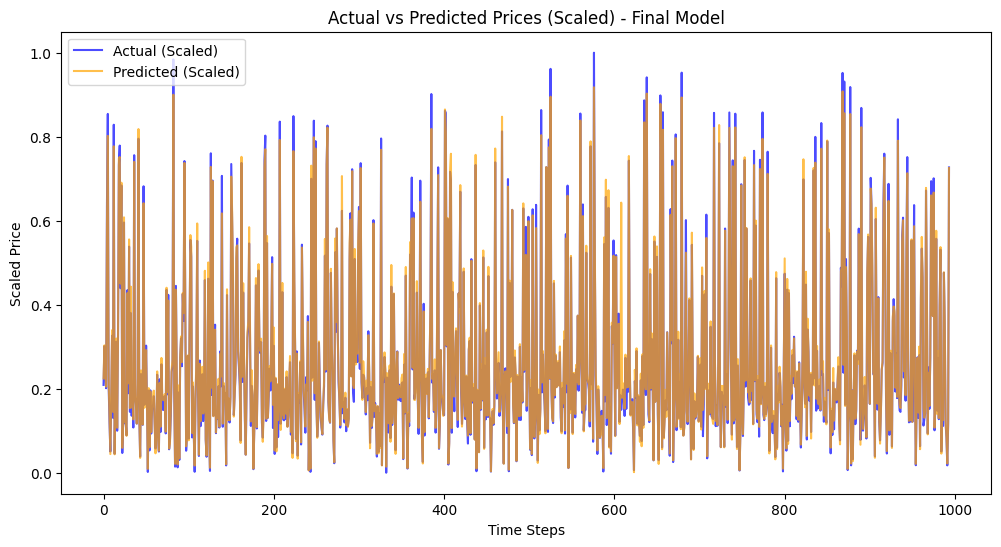

In [15]:
# Build the final model with optimal hyperparameters
final_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30, X_train.shape[2])),
    MaxPooling1D(pool_size=3),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model with optimal learning rate
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model with optimal batch size and epochs
final_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = final_model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test data
y_pred = final_model.predict(X_test)

# Calculate metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Final Model - MSE: {test_mse}")
print(f"Final Model - MAE: {test_mae}")
print(f"Final Model - R2: {test_r2}")

# Plot actual vs predicted prices (scaled)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted (Scaled)', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Prices (Scaled) - Final Model')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()
